<a href="https://colab.research.google.com/github/liangchow/time-series-reservoir-water-level/blob/main/reservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up Worksheet and Import Libraries

In [1]:
# Clone Gitub repository to Colab
from google.colab import drive
drive.mount('/content/drive')

!apt-get install git
!git clone https://github.com/liangchow/time-series-reservoir-water-level.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
fatal: destination path 'time-series-reservoir-water-level' already exists and is not an empty directory.


In [2]:
# Import libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(8,3)}) # Set figure default size
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Read Well Data

In [3]:
# Read well data
file_path = "/content/time-series-reservoir-water-level/field_data/reservoir_well_data.csv"
dfs = pd.read_csv(file_path, skiprows=1)
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        724 non-null    object 
 1   Water_Elev  724 non-null    float64
 2   1A          698 non-null    float64
 3   2A          697 non-null    float64
 4   3A          703 non-null    float64
 5   3B          703 non-null    float64
 6   4A          703 non-null    float64
 7   4B          703 non-null    float64
 8   6A          698 non-null    float64
 9   6B          698 non-null    float64
 10  9A          698 non-null    float64
 11  10A         703 non-null    float64
 12  PH11        657 non-null    float64
 13  PH12        661 non-null    float64
 14  PH13        663 non-null    float64
 15  PH14        633 non-null    float64
 16  P19B        135 non-null    float64
dtypes: float64(16), object(1)
memory usage: 96.3+ KB


In [5]:
# Merge well and vw dataframe, union keys from both df
# dfs = pd.merge(df_w, df_vw, how="outer")

# Drop row # 531 as known wrong format: 10/??/2004
dfs.drop(labels=531, axis=0, inplace=True)

# Parse "Date" column
dfs['Date'] = pd.to_datetime(dfs['Date'])
dfs = dfs.sort_values(by="Date")

# Drop data after 2019/6/27
i = dfs[dfs["Date"] > "2019-06-27"].index
dfs.drop(i, axis=0, inplace=True)
dfs.reset_index()

# Drop "NaT" rows
dfs.dropna(subset="Date", axis=0, inplace=True)

dfs.tail()

,Date,Water_Elev,1A,2A,3A,3B,4A,4B,6A,6B,9A,10A,PH11,PH12,PH13,PH14,P19B
704,2019-02-22,422.04,29.0,72.0,100.0,57.0,130.0,27.0,75.0,26.0,16.0,22.0,24.40,78.61,56.73,40.5,27.37
705,2019-03-29,422.31,28.0,70.0,103.0,85.0,138.0,25.0,73.0,24.0,15.0,25.0,24.95,78.15,57.10,40.5,28.09
706,2019-04-29,421.18,27.0,69.0,100.0,38.0,125.0,28.0,78.0,27.0,14.0,23.0,34.43,77.39,56.68,40.5,28.27
707,2019-05-23,420.17,28.0,72.0,102.0,15.0,122.0,32.0,78.0,30.0,12.0,24.0,24.70,77.53,56.45,40.5,29.35
708,2019-06-27,418.12,26.0,62.0,96.0,13.0,118.0,27.0,72.0,25.0,8.0,18.0,25.02,77.19,56.22,40.5,29.82


# Data Visualization and Resampling
Based on the `dfs.info()` above, the non-null values vary from 135 to 724, meaning that there are missing data all over the place. We will focus mainly on the water elevation. So below, we plot the originally observed data, then resample the dataset to weekly and monthly data. The data line is smoothened with monthly samples. Further below, the weekly-spaced dataset appears to have continuous missing values in the next few data points. This makes the weekly data less meaningful as we have to guess the missing values, e.g. 3 in a row, instead of averaging or interpolating between the previous and the next values.  

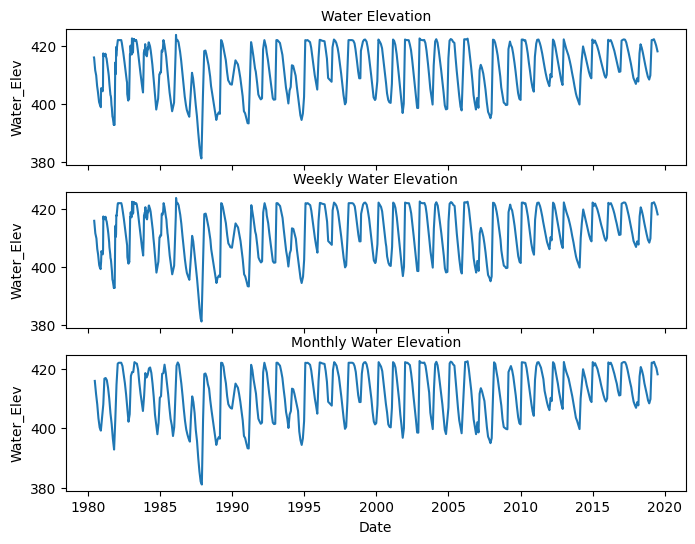

In [6]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(8,6))

sns.lineplot(x=dfs["Date"], y=dfs["Water_Elev"], ax=ax[0])
ax[0].set_title("Water Elevation", fontsize=10)

resampled_dfs = dfs[["Date", "Water_Elev"]].resample("W", on="Date").mean().reset_index()
sns.lineplot(x=resampled_dfs["Date"], y=resampled_dfs["Water_Elev"], ax=ax[1])
ax[1].set_title("Weekly Water Elevation", fontsize=10)

resampled_dfs = dfs[["Date", "Water_Elev"]].resample("M", on="Date").mean().reset_index()
sns.lineplot(x=resampled_dfs["Date"], y=resampled_dfs["Water_Elev"], ax=ax[2])
ax[2].set_title("Monthly Water Elevation", fontsize=10)

plt.show()

In [7]:
# Create a weekly water elevation dateset
dfs_wk = dfs[["Date", "Water_Elev"]].resample("W", on="Date").mean().reset_index(drop=False)

# Check time intervals
dfs_wk["delta"] = dfs_wk["Date"] - dfs_wk["Date"].shift(1)
dfs_wk[["Date", "Water_Elev", "delta"]]

,Date,Water_Elev,delta
0,1980-06-15,415.90,NaT
1,1980-06-22,NaN,7 days
2,1980-06-29,NaN,7 days
3,1980-07-06,NaN,7 days
4,1980-07-13,411.60,7 days
...,...,...,...
2033,2019-06-02,NaN,7 days
2034,2019-06-09,NaN,7 days
2035,2019-06-16,NaN,7 days
2036,2019-06-23,NaN,7 days


In [8]:
# Create a monthly water elevation dateset
dfs_mo = dfs[["Date", "Water_Elev"]].resample("M", on="Date").mean().reset_index(drop=False)

# Check time intervals
dfs_mo["delta"] = dfs_mo["Date"] - dfs_mo["Date"].shift(1)
dfs_mo[["Date", "Water_Elev", "delta"]].head(75)

,Date,Water_Elev,delta
0,1980-06-30,415.90,NaT
1,1980-07-31,411.60,31 days
2,1980-08-31,408.00,31 days
3,1980-09-30,403.35,30 days
4,1980-10-31,400.25,31 days
...,...,...,...
70,1986-04-30,421.30,30 days
71,1986-05-31,418.00,31 days
72,1986-06-30,414.90,30 days
73,1986-07-31,410.80,31 days


# Data Processing
Even though we downsized the data from weekly to monthly, there appears to be some months when there are no data. We can sum all the "NaN" values, resulting in 36 missing values in the entire monthly dataset. There are several ways to fill in the missing values. Here, we interpolate the missing values using the previous and next values.

In [9]:
# Now we can drop "delta" and find NaN within the monthly dataset
dfs_mo.drop('delta', axis=1, inplace=True)
dfs_mo.isna().sum()

Date           0
Water_Elev    36
dtype: int64

In [10]:
# There are 36 "NaN". Interpolate missing values and check if there are any missing values.
dfs_mo['Water_Elev'] = dfs_mo['Water_Elev'].interpolate()
dfs_mo.isna().sum()

Date          0
Water_Elev    0
dtype: int64

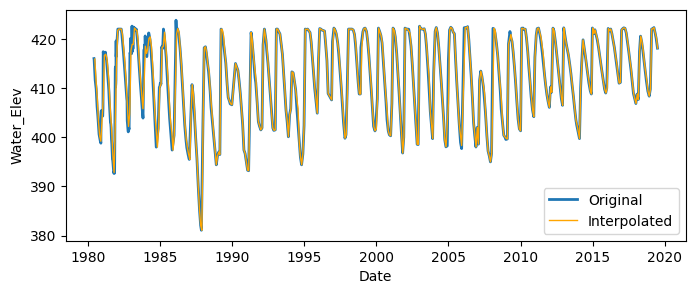

In [11]:
# Plot interpolated data in orange
sns.lineplot(x=dfs["Date"], y=dfs["Water_Elev"], label="Original", lw=2)
sns.lineplot(x=dfs_mo["Date"], y=dfs_mo["Water_Elev"], color="orange", label="Interpolated", lw=1)
plt.show()

# Stationary
The ARIMA time-series model that we are interested in assumes that the underlying data is stationary. That means the data can fluctuates, but the general trend is more or less constant. By visually studying the plot above, we see that the water elevation fluctuates seasonally; however, the overall trend is roughly constant (imagine a horizontal line drawn across the plot). The Augmented Dickey-Fuller test is one statistical test to quatify stationary of a dataset:

- Null Hypothesis (H<sub>0</sub>): Time-series data is not stationary
- Alternate Hypothesis (H<sub>1</sub>): Time-series data is not stationary

If Pearson correlation's p-value returns a value of less than a significant value, which is typically 0.05, we can reject the null hypothesis and conclude that the data is not stationary. Another way is to compare the critical values populated from the `adfuller()` module. If the 1%, 5%, and 10% critical values are greater than the ADF statistical result, we can conclude the dataset is stationary.

Below, we see that p-value is less than 0.05 and the critical values are all greater than the ADT stat results. Therefore, we reject the null hypothesis and conclude that the data is stationary.

In [12]:
# Apply adfuller() from statsmodels.tsa.stattools
res = adfuller(dfs_mo['Water_Elev'].values)
res

(-4.305498698565611,
 0.000434573039986115,
 15,
 453,
 {'1%': -3.444868194858831,
  '5%': -2.867941416548597,
  '10%': -2.5701797149735146},
 2523.841854405455)

In [13]:
print(f"p-value: {res[1]:.5f} < 0.05 ")
print(f"ADF stat: {res[0]:.3f} < 1%: {res[4]['1%']:.3f}, 5%: {res[4]['5%']:.3f} and 10%: {res[4]['10%']:.3f}")

p-value: 0.00043 < 0.05 
ADF stat: -4.305 < 1%: -3.445, 5%: -2.868 and 10%: -2.570


# Decomposition
The time-series decomposition is a simple way to illustrate the data as a combination of level, trend, seasonality, and residual. In a way, it is similar to signal processing, which you decompose a wave into various fourier features. By plotting the decomposed data, we clearly see there is a seasonal fluctuations every year. The trend appears to have the water level trending upward overtime, and finally, the residual or noise, can be as large as 10 to 20 feet of water level variation.

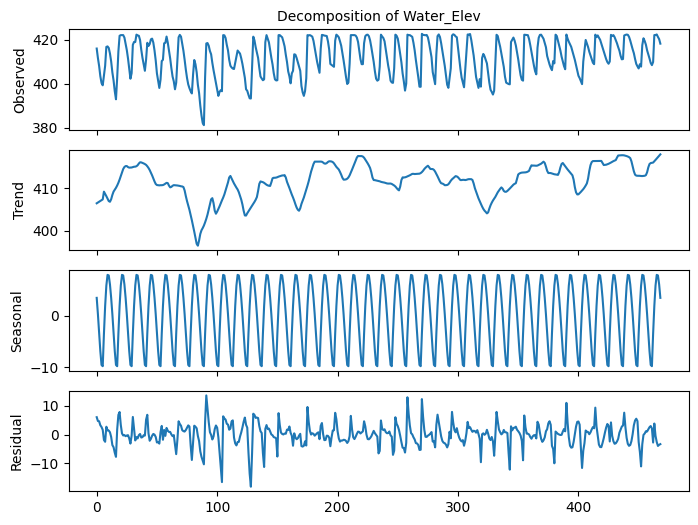

In [14]:
# Apply seasonal_decompose() from statsmodels.tsa.seasonal
decomp = seasonal_decompose(dfs_mo['Water_Elev'], period=12, model="additive", extrapolate_trend="freq")

# Plot decomposed time series
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,6))
ax[0].set_title("Decomposition of Water_Elev", fontsize=10)

decomp.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel("Observed")

decomp.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel("Trend")

decomp.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel("Seasonal")

decomp.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel("Residual")

plt.show()

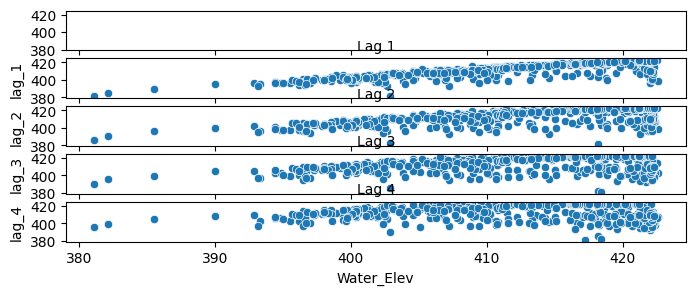

In [32]:
num_lags = 4

fig, ax = plt.subplots(nrows=num_lags+1, ncols=1, sharex=True, sharey=True)

for i in range(1,num_lags+1):
  dfs_mo[f"lag_{i}"] = dfs_mo["Water_Elev"].shift(i)
  sns.scatterplot(x=dfs_mo["Water_Elev"], y=dfs_mo[f"lag_{i}"], ax=ax[i])
  ax[i].set_title(f"Lag {i}", fontsize=10)

plt.show()



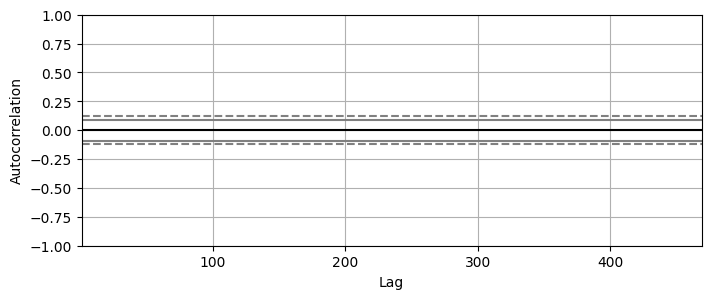

In [27]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(dfs_mo['lag_1'])

plt.show()

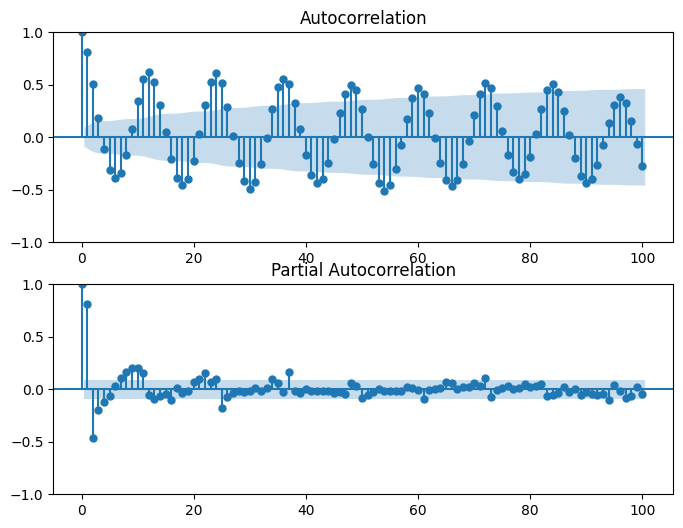

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6))

plot_acf(dfs_mo['Water_Elev'], lags=100, ax=ax[0])
plot_pacf(dfs_mo['Water_Elev'], lags=100, ax=ax[1])

plt.show()